In [ ]:
import os, math, sys
import pandas as pd
import pandapower as pp
import numpy as np

from pandapower.file_io import from_json, to_json

main_dir = os.path.abspath(os.path.join(os.path.abspath(""), ".."))
data_dir = os.path.join(main_dir, 'Modified_116_LV_CSV')

if main_dir not in sys.path:
    sys.path.insert(0, main_dir)

import create_basic_network as cbn

load c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\vitor\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\ortools.dll...

Created External Grid!
Created Transformer!
Created Shunt!
Created 117 Buses!


In [2]:
os.path.exists(os.path.join(data_dir, 'profile_datasource.csv'))

True

In [3]:
from copy import deepcopy

# print(cbn.net)
net = deepcopy(cbn.net)
pp.runpp_3ph(net, init='auto', max_iteration=100, tolerance_mva=1e-5, calc_voltage_angles=True, v_debug=True)
net

This pandapower network includes the following parameter tables:
   - bus (117 elements)
   - shunt (1 element)
   - ext_grid (1 element)
   - line (115 elements)
   - trafo (1 element)
 and the following results tables:
   - res_bus_3ph (117 elements)
   - res_line_3ph (115 elements)
   - res_trafo_3ph (1 element)
   - res_ext_grid_3ph (1 element)
   - res_shunt_3ph (1 element)

In [ ]:
net = from_json(os.path.join(main_dir, 'json_networks', 'full_load_network.json'))
net

: 

In [ ]:
import pandapower.diagnostic as ppdiag

def detailed_diagnostic(net, verbose=True):
    print(">> Iniciando diagnóstico da rede...\n")

    # 1. Diagnóstico do pandapower
    diag_results = ppdiag.diagnose(net)

    if verbose:
        for key, issues in diag_results.items():
            if issues:
                print(f"[!] Problema detectado em '{key}': {issues}")
    
    # 2. Barras desconectadas
    disconnected_buses = diag_results.get("disconnected_buses", [])
    if disconnected_buses:
        print(f"⚠️  {len(disconnected_buses)} barras desconectadas: {disconnected_buses}")

    # 3. Linhas ou trafos com impedância zero
    zero_impedance_lines = net.line[(net.line.r_ohm_per_km == 0) & (net.line.x_ohm_per_km == 0)]
    if not zero_impedance_lines.empty:
        print(f"⚠️  Linhas com impedância zero:\n{zero_impedance_lines}")

    zero_impedance_trafo = net.trafo_3ph[net.trafo_3ph.vn_hv_kv == 0]
    if not zero_impedance_trafo.empty:
        print(f"⚠️  Transformadores com tensão nominal zero:\n{zero_impedance_trafo}")

    # 4. Verificação de perfis de controle
    if "controller" in net and not net.controller.empty:
        nan_profiles = []
        for ctrl in net.controller.itertuples():
            ds = ctrl.data_source
            pname = ctrl.profile_name
            if isinstance(pname, list):
                for name in pname:
                    if name not in ds.data or ds.data[name].isnull().all():
                        nan_profiles.append(name)
            elif pname not in ds.data or ds.data[pname].isnull().all():
                nan_profiles.append(pname)
        if nan_profiles:
            print(f"⚠️  Perfis inválidos ou NaN detectados: {nan_profiles}")
    else:
        print("⚠️  Nenhum controlador foi encontrado na rede.")

    # 5. Tensões iniciais muito baixas
    if hasattr(net, "res_bus_3ph") and not net.res_bus_3ph.empty:
        low_voltages = net.res_bus_3ph[
            (net.res_bus_3ph.vm_a_pu < 0.7) |
            (net.res_bus_3ph.vm_b_pu < 0.7) |
            (net.res_bus_3ph.vm_c_pu < 0.7)
        ]
        if not low_voltages.empty:
            print(f"⚠️  Tensões iniciais baixas detectadas:\n{low_voltages}")

    print("\n>> Diagnóstico completo.")
    return diag_results

detailed_diagnostic(net)

In [10]:
profile_df, ds = cbn.create_data_source(data_dir)
print(f"Created {ds} {ds.df.shape}")
profile_df.head(10)

Created DFData (1440, 110)


,LOAD1,LOAD1_Q,LOAD2,LOAD2_Q,LOAD3,LOAD3_Q,LOAD4,LOAD4_Q,LOAD5,LOAD5_Q,...,LOAD51,LOAD51_Q,LOAD52,LOAD52_Q,LOAD53,LOAD53_Q,LOAD54,LOAD54_Q,LOAD55,LOAD55_Q
time,,,,,,,,,,,,,,,,,,,,,
00:01:00,0.000036,0.000012,0.000044,0.000014,0.000054,0.000018,0.000048,0.000016,0.000035,0.000012,...,0.000053,0.000017,0.000052,0.000017,0.000047,0.000015,0.000048,0.000016,0.000055,0.000018
00:02:00,0.000036,0.000012,0.000044,0.000014,0.000054,0.000018,0.000048,0.000016,0.000035,0.000012,...,0.000053,0.000017,0.000052,0.000017,0.000047,0.000015,0.000048,0.000016,0.000055,0.000018
00:03:00,0.000036,0.000012,0.000044,0.000014,0.000054,0.000018,0.000048,0.000016,0.000035,0.000012,...,0.000053,0.000017,0.000052,0.000017,0.000047,0.000015,0.000057,0.000019,0.000055,0.000018
00:04:00,0.000036,0.000012,0.000044,0.000014,0.000054,0.000018,0.000227,0.000075,0.000035,0.000012,...,0.000053,0.000017,0.000052,0.000017,0.000047,0.000015,0.000048,0.000016,0.000055,0.000018
00:05:00,0.000036,0.000012,0.000044,0.000014,0.000054,0.000018,0.000227,0.000075,0.000035,0.000012,...,0.000053,0.000017,0.000052,0.000017,0.000047,0.000015,0.000048,0.000016,0.000055,0.000018
00:06:00,0.000036,0.000012,0.000044,0.000014,0.000054,0.000018,0.000227,0.000075,0.000035,0.000012,...,0.000053,0.000017,0.000052,0.000017,0.000047,0.000015,0.000048,0.000016,0.000055,0.000018
00:07:00,0.000036,0.000012,0.000044,0.000014,0.000054,0.000018,0.000227,0.000075,0.000147,0.000048,...,0.000053,0.000017,0.000052,0.000017,0.000047,0.000015,0.000048,0.000016,0.000055,0.000018
00:08:00,0.000036,0.000012,0.000044,0.000014,0.000054,0.000018,0.000227,0.000075,0.000147,0.000048,...,0.000053,0.000017,0.000052,0.000017,0.000047,0.000015,0.000148,0.000049,0.000055,0.000018
00:09:00,0.000036,0.000012,0.000044,0.000014,0.000054,0.000018,0.000227,0.000075,0.000147,0.000048,...,0.000053,0.000017,0.000052,0.000017,0.000047,0.000015,0.000148,0.000049,0.000055,0.000018


In [7]:
loads_df = pd.read_excel(os.path.join(data_dir, "Loads.xlsx"), skiprows=2)
loadShape_df = pd.read_csv(os.path.join(data_dir, 'LoadShapes.csv'), skiprows=1, sep=';')
loads_df.head(), loadShape_df.head()

merged_load = loads_df.merge(loadShape_df, left_on="Yearly", right_on="Name", how="left")
merged_load.head(10)

,Name_x,numPhases,Bus,phases,kV,Model,Connection,kW,PF,Yearly,Name_y,npts,minterval,File,useactual
0,LOAD1,1,5.0,A,0.23,1,wye,1,0.95,Shape_1,Shape_1,1440,1,Load_profile_1.csv,True
1,LOAD2,1,7.0,B,0.23,1,wye,1,0.95,Shape_2,Shape_2,1440,1,Load_profile_2.csv,True
2,LOAD3,1,10.0,A,0.23,1,wye,1,0.95,Shape_3,Shape_3,1440,1,Load_profile_3.csv,True
3,LOAD4,1,11.0,A,0.23,1,wye,1,0.95,Shape_4,Shape_4,1440,1,Load_profile_4.csv,True
4,LOAD5,1,12.0,A,0.23,1,wye,1,0.95,Shape_5,Shape_5,1440,1,Load_profile_5.csv,True
5,LOAD6,1,13.0,B,0.23,1,wye,1,0.95,Shape_6,Shape_6,1440,1,Load_profile_6.csv,True
6,LOAD7,1,21.0,B,0.23,1,wye,1,0.95,Shape_7,Shape_7,1440,1,Load_profile_7.csv,True
7,LOAD8,1,25.0,C,0.23,1,wye,1,0.95,Shape_8,Shape_8,1440,1,Load_profile_8.csv,True
8,LOAD9,1,26.0,A,0.23,1,wye,1,0.95,Shape_9,Shape_9,1440,1,Load_profile_9.csv,True
9,LOAD10,1,29.2,B,0.23,1,wye,1,0.95,Shape_10,Shape_10,1440,1,Load_profile_10.csv,True


In [18]:
f"test_list: {' '.join([str(i) for i in net.asymmetric_load.index])}"

'test_list: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54'

In [ ]:
ts_data = {}

for _, row in merged_load.iterrows():
    # print(row["File"])
    file_path = os.path.join(data_dir, 'Load Profiles', row["File"])
    try:
        profile = pd.read_csv(file_path)
        ts_data[row["Name_x"]] = profile["mult"].values * 1e-3 # or .to_numpy()
    except:
        profile = pd.read_csv(file_path, sep=';')
        ts_data[row["Name_x"]] = profile["mult"].values * 1e-3 # or .to_numpy()
    # finally:
    #     ts_data[row["Name_x"]] = profile["mult"].values * 1e-3 # or .to_numpy()

profile_df = pd.DataFrame(ts_data, index=profile.time)
profile_df.head(10)

In [ ]:
import create_basic_network as cbn

profile_df2 = cbn.create_data_source(data_dir=data_dir, profile_dir=os.path.join(data_dir, 'Load Profiles'))
profile_df2

In [ ]:
from copy import deepcopy
import pandapower.control as ppc

net = cbn.net
ds = cbn.create_data_source(data_dir, profile_dir=os.path.join(data_dir, 'Load Profiles'), ds_index=True)
load_map = {}

for _, row in loads_df.iterrows():
    bus_id = math.floor(row['Bus'])
    pa = qa = pb = qb = pc = qc = 0

    if (bus_id in net.bus.name) and (row['phases'] in {'A', 'B', 'C'}):
        if row['phases'] == 'A':
            pa = row['kW']
            qa = row['kW'] * np.tan(np.arccos(row['PF']))
        elif row['phases'] == 'B':
            pb = row['kW']
            qb = row['kW'] * np.tan(np.arccos(row['PF']))
        else:  # 'C'
            pc = row['kW']
            qc = row['kW'] * np.tan(np.arccos(row['PF']))

        load = pp.create_asymmetric_load(
            net, bus=net.bus.index[net.bus.name == bus_id][0],
            p_a_mw=pa / 1000, q_a_mvar=qa / 1000,
            p_b_mw=pb / 1000, q_b_mvar=qb / 1000,
            p_c_mw=pc / 1000, q_c_mvar=qc / 1000,
            name=row['Name']
        )
        load_map[load] = row['Yearly']

        # Attach ConstControl
        phase = row['phases'].lower()
        ppc.ConstControl(
            net, element_index=load,
            variable=f"p_{phase}_mw",
            element="asymmetric_load",
            profile_name=row['Name'], data_source=ds
        )
        # print(f"Created {net.controller.object.iloc[load+1].profile_name}")

In [ ]:
pp.runpp_3ph(net, max_iteration=1000, tolerance_mva=1e-5)
print("res_bus_3ph:", net.res_bus_3ph.index)

In [ ]:
print(len(profile_df2.df))
profile_df2.df.index

In [ ]:
print(f"Trafobus: {cbn.net.trafo.hv_bus.values[0]}, Bus Indexes: {cbn.net.res_bus_3ph.index}")

Trafobus: 0, Bus Indexes: Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116],
      dtype='int64', length=117)


In [ ]:
import pandapower.control as ppc
pq_area = ppc.controller.DERController.PQVAreas.PQArea4105(variant=1)
type(pq_area)

In [ ]:
import pandapower.control as ppc
from pandapower.timeseries.data_sources.frame_data import DFData

net48 = from_json(os.path.join(main_dir, 'json_networks', '48_loads_network.json'))
# net48.asymmetric_load.head(10)

filtered_loads = merged_load[merged_load["Name_x"].isin(net48.asymmetric_load.name.values)]

ds = DFData(profile_df)

for load_name in net48.asymmetric_load.name:
    # get the index of the corresponding load
    idx = net48.asymmetric_load[net48.asymmetric_load.name == load_name].index[0]

    # find phase from the merged metadata
    phase = filtered_loads[filtered_loads["Name_x"] == load_name]["phases"].values[0].lower()

    ppc.ConstControl(
        net48, element_index=idx,
        variable=f"p_{phase}_mw",
        element=f"asymmetric_load",
        profile_name=net48.asymmetric_load.name.at[idx], data_source=ds
    )

    
net48.controller.head(10)

In [ ]:
output_dir = os.path.join(main_dir, "timeseries_results")

if not os.path.exists(output_dir): os.mkdir(output_dir)

In [ ]:
def get_kwarg(a, **kwargs):
    ds_index = kwargs.get('ds_index')
    ds_index = False if ds_index is None else ds_index
    print(a, 'ds_index =', ds_index)
get_kwarg(0, ds_index=True)

In [ ]:
from pandapower.timeseries import run_timeseries
from pandapower.timeseries import OutputWriter

net48 = from_json(os.path.join(main_dir, 'json_networks', '48_loads_network.json'))
net48

# Create and attach output writer to net48
# ow48 = OutputWriter(net48, time_steps=range(profile_df.shape[0]), output_path=output_dir)
# # Log desired variables
# ow48.log_variable('res_trafo_3ph', 'loading_percent', index=net48.trafo.index[0])

# ow48.log_variable('res_bus_3ph', 'vm_b_pu', index=[32, 26]) # LOAD2 and LOAD23
# ow48.log_variable('res_bus_3ph', 'vm_a_pu', index=[14]) # LOAD55

run_timeseries(net48, time_steps=range(profile_df.shape[0]), run=pp.runpp_3ph, continue_on_divergence=False)

In [ ]:
net = from_json(os.path.join(main_dir, 'json_networks', 'no_load_network.json'))

# Create Loads
loads_df = pd.read_excel(os.path.join(data_dir, "Loads.xlsx"), skiprows=2)
# print(loads_df.head(10))

net.asymmetric_load.drop(net.asymmetric_load.index, inplace=True)
load_map = {}
for _, row in loads_df.iterrows():
    # print(_, '->', row)
    bus_id = math.floor(row['Bus'])
    pa = qa = pb = qb = pc = qc = 0
    if (bus_id in net.bus.name) & (row['phases'] in {'A', 'B', 'C'}):
        if row['phases']=='A':
            pa = row['kW']
            qa = row['kW'] * np.tan(np.arccos(row['PF']))
        elif row['phases']=='B':
            pb = row['kW']
            qb = row['kW'] * np.tan(np.arccos(row['PF']))
        else: # row['phases']=='C'
            pc = row['kW']
            qc = row['kW'] * np.tan(np.arccos(row['PF']))
        load = pp.create_asymmetric_load(
            net, bus=net.bus.index[net.bus.name==bus_id][0],
            p_a_mw=pa / 1000, q_a_mvar=qa / 1000,
            p_b_mw=pb / 1000, q_b_mvar=qb / 1000,
            p_c_mw=pc / 1000, q_c_mvar=qc / 1000,
            name=row['Name']
        )
        load_map[load] = row['Yearly']
net

In [ ]:
import pandapower.control as ppc
from pandapower.timeseries.data_sources.frame_data import DFData

ds = DFData(profile_df)

for load_name in net.asymmetric_load.name:
    # get the index of the corresponding load
    idx = net.asymmetric_load[net.asymmetric_load.name == load_name].index[0]

    # find phase from the merged metadata
    phase = merged_load[merged_load["Name_x"] == load_name]["phases"].values[0].lower()

    ppc.ConstControl(
        net, element_index=idx,
        element="asymmetric_load",
        element_name=f"CTRL_{net.asymmetric_load.name.at[idx]}",
        variable=f"p_{phase}_mw",
        profile_name=load_name, data_source=ds
    )
net

In [26]:
from pandapower.timeseries import run_timeseries
from pandapower.timeseries import OutputWriter

output_dir = os.path.join(main_dir, 'timeseries_results')

# Create and attach output writer to net48
ow = OutputWriter(net, time_steps=ds.df.index, output_path=output_dir)
# Log desired variables
ow.log_variable('res_trafo_3ph', 'loading_percent', index=net.trafo.index[0])

ow.log_variable('res_bus_3ph', 'vm_a_pu', index=net.bus.index)
ow.log_variable('res_bus_3ph', 'vm_b_pu', index=net.bus.index)
ow.log_variable('res_bus_3ph', 'vm_c_pu', index=net.bus.index)

ow.log_variable('res_line_3ph', 'loading_a_percent', index=net.line.index)
ow.log_variable('res_line_3ph', 'loading_b_percent', index=net.line.index)
ow.log_variable('res_line_3ph', 'loading_c_percent', index=net.line.index)

ow.remove_log_variable('res_bus', 'vm_pu')
ow.remove_log_variable('res_line', 'loading_percent')

run_timeseries(net, time_steps=ds.df.index, run=pp.runpp_3ph, run_control=True, continue_on_divergence=True)

  0%|          | 0/1440 [00:00<?, ?it/s]

100%|██████████| 1440/1440 [05:29<00:00,  4.37it/s]


In [38]:
net.res_bus_3ph[['vm_a_pu', 'vm_b_pu', 'vm_c_pu']].max().tolist()

[1.1536411437144907, 1.049985730862301, 1.1383878809195744]

In [41]:
net.res_line_3ph[['loading_a_percent', 'loading_b_percent', 'loading_c_percent']].max().tolist()

[4.10199656566172, 5.0519553824022605, 2.480650605973161]

In [44]:
net.res_trafo_3ph.loading_percent.tolist()

[2.8810742772745175]

In [18]:
ow.output

{'Parameters':          time_step  controller_unstable  powerflow_failed
 time                                                     
 00:01:00  00:01:00                False             False
 00:02:00  00:02:00                False             False
 00:03:00  00:03:00                False             False
 00:04:00  00:04:00                False             False
 00:05:00  00:05:00                False             False
 ...            ...                  ...               ...
 23:56:00  23:56:00                False             False
 23:57:00  23:57:00                False             False
 23:58:00  23:58:00                False             False
 23:59:00  23:59:00                False             False
 24:00:00  24:00:00                False             False
 
 [1440 rows x 3 columns],
 'res_trafo_3ph.loading_percent':                  0
 time              
 00:01:00  2.881074
 00:02:00  2.881074
 00:03:00  2.881074
 00:04:00  2.881074
 00:05:00  2.881074
 ...            ..

In [33]:
ow.output['res_trafo_3ph.loading_percent']

,0
time,
00:01:00,2.881074
00:02:00,2.881074
00:03:00,2.881074
00:04:00,2.881074
00:05:00,2.881074
...,...
23:56:00,2.881074
23:57:00,2.881074
23:58:00,2.881074


In [34]:
ow.output['res_bus_3ph.vm_a_pu'].max()

0      1.050026
1      1.153641
2      1.153038
3      1.152980
4      1.152774
         ...   
112    1.151173
113    1.150765
114    1.150976
115    1.151168
116    1.150830
Length: 117, dtype: float64

In [32]:
ow.output.get('res_bus_3ph.vm_a_pu')

,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
time,,,,,,,,,,,,,,,,,,,,,
00:01:00,1.050026,1.153641,1.153038,1.15298,1.152774,1.152977,1.152775,1.152776,1.152237,1.152178,...,1.151214,1.150976,1.150838,1.150976,1.151176,1.151173,1.150765,1.150976,1.151168,1.15083
00:02:00,1.050026,1.153641,1.153038,1.15298,1.152774,1.152977,1.152775,1.152776,1.152237,1.152178,...,1.151214,1.150976,1.150838,1.150976,1.151176,1.151173,1.150765,1.150976,1.151168,1.15083
00:03:00,1.050026,1.153641,1.153038,1.15298,1.152774,1.152977,1.152775,1.152776,1.152237,1.152178,...,1.151214,1.150976,1.150838,1.150976,1.151176,1.151173,1.150765,1.150976,1.151168,1.15083
00:04:00,1.050026,1.153641,1.153038,1.15298,1.152774,1.152977,1.152775,1.152776,1.152237,1.152178,...,1.151214,1.150976,1.150838,1.150976,1.151176,1.151173,1.150765,1.150976,1.151168,1.15083
00:05:00,1.050026,1.153641,1.153038,1.15298,1.152774,1.152977,1.152775,1.152776,1.152237,1.152178,...,1.151214,1.150976,1.150838,1.150976,1.151176,1.151173,1.150765,1.150976,1.151168,1.15083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23:56:00,1.050026,1.153641,1.153038,1.15298,1.152774,1.152977,1.152775,1.152776,1.152237,1.152178,...,1.151214,1.150976,1.150838,1.150976,1.151176,1.151173,1.150765,1.150976,1.151168,1.15083
23:57:00,1.050026,1.153641,1.153038,1.15298,1.152774,1.152977,1.152775,1.152776,1.152237,1.152178,...,1.151214,1.150976,1.150838,1.150976,1.151176,1.151173,1.150765,1.150976,1.151168,1.15083
23:58:00,1.050026,1.153641,1.153038,1.15298,1.152774,1.152977,1.152775,1.152776,1.152237,1.152178,...,1.151214,1.150976,1.150838,1.150976,1.151176,1.151173,1.150765,1.150976,1.151168,1.15083


In [ ]:
def test_ow(**kwargs):
    ow = kwargs.get('output_writer_data')
    max = kwargs.get('max_lim', 100)
    to_bus = kwargs.get('to_bus', net.bus.index[-1] + 1)
    # print(ow)
    res_bus_max = [ow.get('res_bus_3ph.vm_a_pu').max().max(), 
                       ow.get('res_bus_3ph.vm_b_pu').max().max(), 
                       ow.get('res_bus_3ph.vm_c_pu').max().max()]
    # res_bus_max > 1.1
    res_trafo = ow.get('res_trafo_3ph.loading_percent').max() > 0
    print(max)
    print(any([rbm > 1.1 for rbm in res_bus_max]))
    print(res_trafo > 100)

In [71]:
test_ow(output_writer_data=ow.output)

100
True


0    False
dtype: bool


In [ ]:
vm_a_pu = pd.read_pickle(os.path.join(output_dir, 'res_bus_3ph', 'vm_a_pu.p'))
vm_b_pu = pd.read_pickle(os.path.join(output_dir, 'res_bus_3ph', 'vm_b_pu.p'))
vm_c_pu = pd.read_pickle(os.path.join(output_dir, 'res_bus_3ph', 'vm_c_pu.p'))

trafo_loading = pd.read_pickle(os.path.join(output_dir, 'res_trafo_3ph', 'loading_percent.p'))

vm_a_pu.shape, vm_b_pu.shape, vm_c_pu.shape, trafo_loading.shape

In [ ]:
vm_a_pu.to_csv(os.path.join(output_dir, 'vm_a_pu.csv'))
vm_b_pu.to_csv(os.path.join(output_dir, 'vm_b_pu.csv'))
vm_c_pu.to_csv(os.path.join(output_dir, 'vm_c_pu.csv'))
net.res_bus_3ph.to_csv(os.path.join(output_dir, 'net.res_bus_3ph.csv'))
trafo_loading.to_csv(os.path.join(output_dir, 'trafo_loading_percent.csv'))

vm_a_pu.head(20)

In [ ]:
trafo_loading.describe()

In [74]:
net.bus.index[2:]

Index([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
       ...
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116],
      dtype='int64', length=115)

In [ ]:
ds.df.loc[:, ]

KeyError: 0

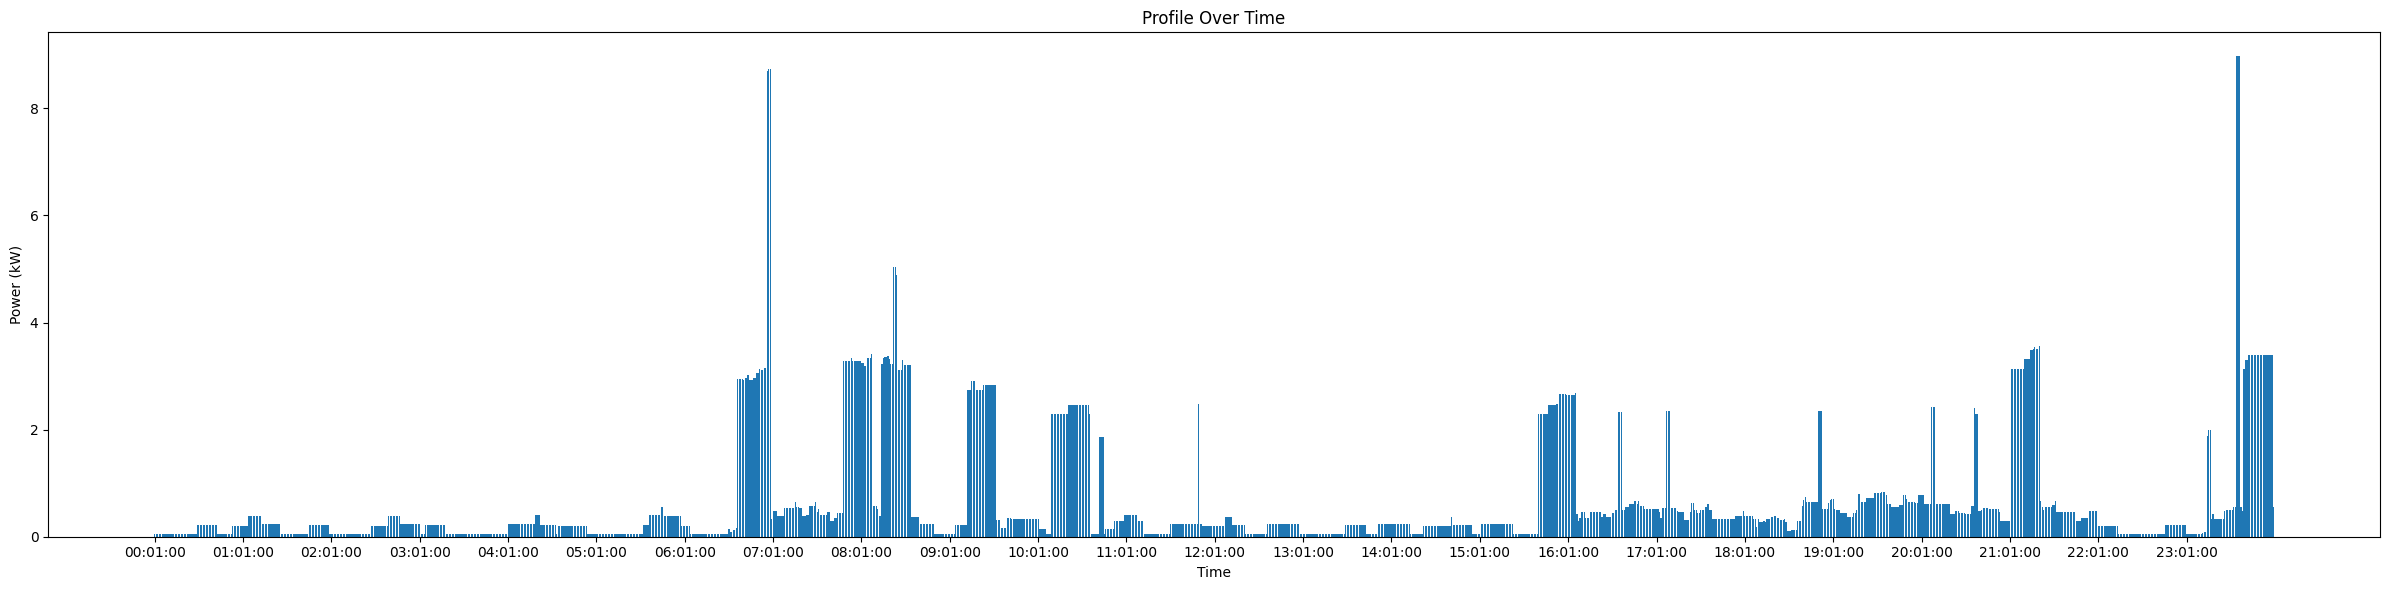

In [ ]:
# %matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

i=14
# Plotting vertical bar chart
plt.figure(figsize=(24, 6))
plt.bar(ds.df.index, ds.df.iloc[:, i] * 1e3)
step = 60  # show one tick per hour
plt.xticks(ticks=ds.df.index[::step], labels=ds.df.index[::step], rotation=0)
plt.title("Profile Over Time")
plt.xlabel("Time")
plt.ylabel("Power (kW)")

plt.tight_layout()
# plt.show()

# plot_path = os.path.join(main_dir, 'images', f"LOAD{i+1}_timeseries.png")
# plt.savefig(plot_path)

Simulating PV behavior profile

In [ ]:
len(ds.df)

1440

In [ ]:
minutes = len(ds.df)
t = np.arange(0, minutes)
pv_max_kw = 0.5  # example peak capacity

# Simple symmetric profile peaking at noon (720 minutes)
pv_base = 0.9 * pv_max_kw * np.cos(np.pi * 2*t / 1440 + np.pi)
pv_base = np.clip(pv_base, 0, None)

noise = np.random.normal(0, 0.5, size=minutes)
pv_noise = pd.Series(pv_base) * (1 + pd.Series(noise).rolling(15, center=True).mean().fillna(0))
pv_profile = np.clip(pv_noise, 0, pv_max_kw) * 1e-3

In [ ]:
int(np.random.choice(range(56,101)))

77

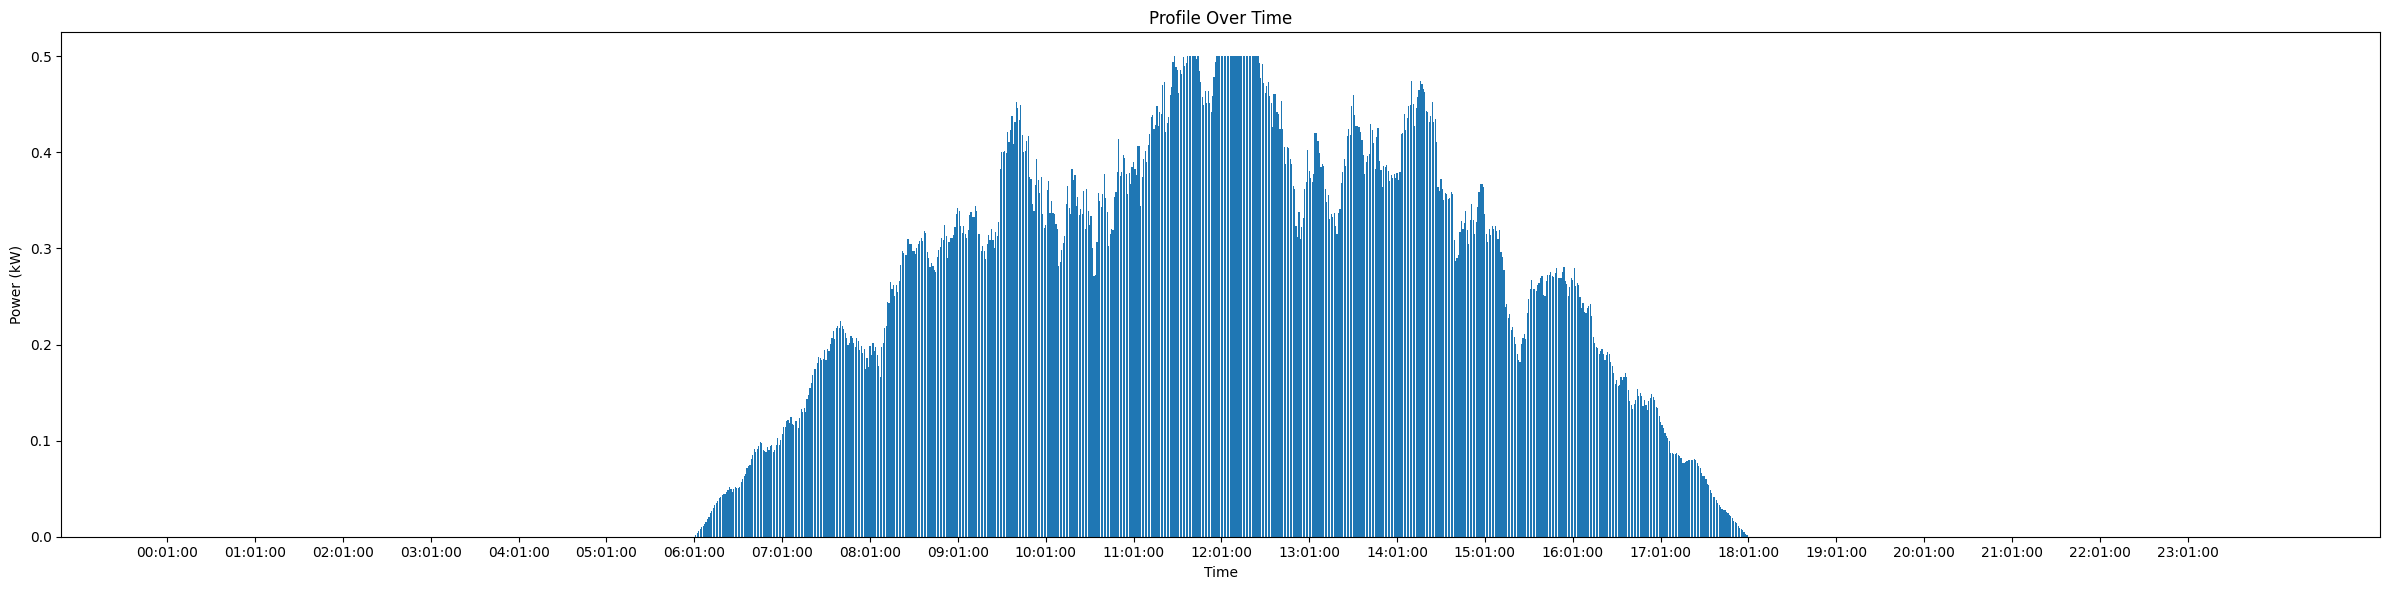

In [ ]:
# Plotting vertical bar chart
plt.figure(figsize=(24, 6))
plt.bar(ds.df.index, pv_profile * 1e3)
step = 60  # show one tick per hour
plt.xticks(ticks=ds.df.index[::step], labels=ds.df.index[::step], rotation=0)
plt.title("Profile Over Time")
plt.xlabel("Time")
plt.ylabel("Power (kW)")

plt.tight_layout()

In [ ]:
pv, ev = (True, True)
elements = []
if pv: elements.append('PV')
if ev: elements.append('EV')
f"{''.join(elements)}_scenario"

'PVEV_scenario'

In [7]:
import pp_simu
net48 = from_json(os.path.join(main_dir, 'json_networks', '48_loads_network.json'))
pp_simu.addPV(net48, bus=25, phase='A', kw=10)
net48
pp.runpp_3ph(net48)

1 PV Gen created so far...


LoadflowNotConverged: Power Flow nr did not converge after 30 iterations!

In [4]:
net = from_json(os.path.join(main_dir, 'json_networks', 'full_load_network.json'))

print(net.res_bus_3ph.head())
print(net.res_line_3ph.head())
print(net.res_trafo_3ph.head())

    vm_a_pu  va_a_degree   vm_b_pu  va_b_degree   vm_c_pu  va_c_degree  \
0  1.050026    -0.000092  1.049986  -120.001166  1.049989   120.001257   
1  1.153641   -22.885419  0.878572  -149.441300  1.138388    82.195437   
2  1.153038   -22.864754  0.877623  -149.462750  1.138362    82.189889   
3  1.152980   -22.864050  0.877623  -149.462802  1.138362    82.189924   
4  1.152774   -22.853773  0.877063  -149.472801  1.138327    82.185070   

     p_a_mw  q_a_mvar   p_b_mw  q_b_mvar    p_c_mw  q_c_mvar  \
0 -0.007002  0.003827 -0.00743   0.00314 -0.006622  0.003112   
1  0.000000  0.000000  0.00000   0.00000  0.000000  0.000000   
2  0.000000  0.000000  0.00000   0.00000  0.000000  0.000000   
3  0.000000  0.000000  0.00000   0.00000  0.000000  0.000000   
4  0.000000  0.000000  0.00000   0.00000  0.000000  0.000000   

   unbalance_percent  
0           0.002447  
1           0.008800  
2           0.012758  
3           0.011203  
4           0.017252  
   p_a_from_mw  q_a_from_mvar   